# Generación de datos sintéticos de radar metereológico sobremuestreado en rango

## Objetivos:

* Generar datos sintéticos de radar meteorológico correlacionados en rango.
* Generar correlación en tiempo a los datos correlacionados en rango.




## Fundamentos:
Este método propone sobremuestrar en rango, es decir las muestras IQ se adquieren a una tasa $L$ veces más rápida que el reciproco del ancho de banda del pulso, $\tau$.

La potencia media del pulso que medimos no varía sufiente al momento de adquirir las muestras en rango y podemos conocer completamente la correlación a priori, tan solo mediante la forma de la envolvente del pulso transmitido y la respuesta impulsional del receptor, $h(t)$.

El voltaje en el receptor debido a la resoloción de volumen escaneada es: $$V(nT_s)= I(nT_s)+jQ(nT_s)$$
donde, $n$ indexa entre los distintos $M$ pulsos sucesivos que se envían y $T_s$ es intervalo de repetición de pulso. Para un pulso dado, podemos descomponerlo en $L$ contribuciónes de los slabs contiguos: $$s(l\tau_0, nT_s)$$
donde $\tau_0 = \frac{\tau}{L}$ es el tiempo de muestreo rápido. Por simplicidad se utiliza: $$s(l,n)$$ donde $l$ indexa en rango con incrementos de $\tau_0$ y $n$ en tiempo con incrementos de $T_s$. 

Propiedades estadísticas de $s(l,n)$:
* Son iid, VAs gaussianas complejas, de media nula y varianza unitaria.

### Correlación en rango

Dada la forma de envolvente del pulso por $p(l)$ y la respuesta impulsiva del receptor por $h(l)$, los voltajes producidos por los slabs contribuyen al voltaje en el receptor como: 
$$V(l,n) = I(l,n)+jQ(l,n)= [ \sum _{i=0}^{L-1} s(l+i,n)p(L-1-i)] \star h(l)$$

donde $\star$ denota la operación convolución. Luego, la autocorrelación de los datos en muestras de rango está dada por: $$R_V ^{(R)}(m)= E [V^*(l,n)V(l+m,n)] = \sigma_s^2[p_m(m)\star p_m^*(-m)]$$

donde $p_m(m)=p(m)\star h(m)$ y el superíndice $(R)$ indica que hablamos de rango.

### Correlación en tiempo

El radar envía pulsos suficientemente rápido por lo que los fenómenos atmósfericos causan muestras correlacionadas. Se toma cada localización de rango en intervalos de $nT_s$. Se asume que la correlación en tiempo de señales meteorológicas es Gaussiana y está dada por:
$$R_V ^{(T)}(m)= E [V^*(l,n)V(l,n+m)] = S e^{-8(\frac{\pi \sigma_v m T_s}{\lambda})^2} e^{-j4\pi \overline{v}m\frac{T_s}{\lambda}}$$
donde: 
* Superíndice $T$ indica sample-time.
* $\lambda$ es la longitud de onda del radar
* S es la potencia media de la señal 
* $\sigma_v$ el ancho de banda del espectro asociado.
* $\overline{v}$ es la velocidad media Doppler.




## Algoritmo

* Se procede a crear $s(l,n)$ iid, VAs gaussianas complejas, de media nula y varianza unitaria.
* A la señal generada se le agrega la correlación en rango mediante:
$$V_2(l,n) = [ \sum _{i=0}^{L-1} s(l+i,n)p(L-1-i)] \star h(l)$$
donde se han acomodado los largos de la secuencia para eliminar el transitorio. $V_2(l,n)$ es una matriz de dimensión $LxM$.

A la señal con correlación en rango se le agrega correlación en tiempo, para hacerlo se utiliza un procedimiento de coloreo.
* Se aplica la transformada discreta de Fourier a $V_2(l,n)$ para un dado $l$.
* El espectro de potencia es: 
$$ \zeta(v_k) = \frac{S}{\sqrt{2\pi}\sigma_v G}e^{-\frac{(v_k-\bar{v})^2}{2\sigma_v ^2}}$$
donde $G$ es la potencia de la señal con correlación en rango, $\sigma_v$ es el ancho de banda Doppler, $\bar{v}$ es la velocidad Doppler y $v_k$ es un vector que recorre desde $-3v_a$ hasta $3v_a$, $v_a$ es la velocidad ambigüa, y se utiliza para agregar el efecto de aliasing. 
* Se trunca $\zeta(vk)$ al intervalo Nyquist, es de decir $-v_a \leq v \leq v_a$, se hace un flip para pasar al eje de frecuencias y se obtiene: $\zeta'(k)$, con $0\leq k<M$.
* Ahora se aplica la transormada inversa de Fourier al producto de $\zeta'(k)$ y la transformada de Fourier de $V_2(l,n)$:
$$ V(l,n) =  \mathscr{F}^{-1}( \mathscr{F}(V_2(l,n)*\sqrt{\zeta'(k)} ) $$
con $0 \leq l < L$.
* Agremamos ruido blanco Gaussiano de potencia $P_n$.

## Implementación

In [5]:
import numpy as np


def datos_sinteticos(M, L, F, p_l, h_l, S, Pn, v_mean, sigma_v, lamb, v_amax):
    """

    ================================INPUTS===================================
    M          : número de pulsos

    L          : número de muestras en range-time (factor de oversampling)

    F          : largo de la respuesta impulsional del filtro receptor

    p_l        : envolvente del pulso transmitido

    h_l        : respuesta impulsional del receptor

    S          : potencia media del a señal

    Pn         : potencia media del ruido blanco Gaussiano aditivo

    v_mean     : velocidad media Doppler

    sigma_v    : ancho de banda Doppler

    lamb       : longitud de onda del Radar

    v_amax     : máx velocidad no ambigüa 

    ==============================OUTPUTS===============================
    
    V_ln       : señal de radar meteorológico sobremuestreada en rango
    """ 
    
    # Expresamos las potencias en veces

    S= 10**((S-30)/10)
    Pn= 10**((Pn-30)/10)

    # Genero la la contribución de voltajes sq, IID CN(0,1).

    sq= np.random.normal(0, 1/np.sqrt(2), size=(2*L+F-1, M)) + \
   1j*np.random.normal(0, 1/np.sqrt(2), size=(2*L+F-1, M)) 

    # Generamos la correlación en rango

    V_1= np.zeros((L, M),dtype = 'complex_')

    for j in range(M):
        for i in range(L):
         V_1[i,j]= np.dot(sq[i:i+L,j],np.flip(p_l))

    # Convolucionamos con el receptor (importante para el caso de receptor no ideal)

    V_2= np.zeros((L+F-1,M), dtype= 'complex_') # Tiene el largo de V1 + H_l - 1

    for k in range(M):

            V_2[:,k]= np.convolve( V_1[:,k], h_l, "full")

    # Hago un reshape para borrar el transitorio y me quedo con los L valores de interes

    V_2= V_2[-L:]

    # Potencia media de la señal luego de agregar correlación en rango

    G= sum(np.absolute(np.convolve(h_l, p_l, 'full'))**2)

    # Generamos la correlación en tiempo, coloreo de espectro.

    k= np.arange(-M, 2*M, 1, dtype=int) 

    v_k= -v_amax + 2*k*v_amax/M # Vector que recorre desde -3Vamax a 3Vamax, para el aliasing

    Pow_sepec= S*2*v_amax/(np.sqrt(2*np.pi)*sigma_v*G) *np.exp((-1*(v_k-v_mean)**2)/(2*sigma_v**2)) # Espectro Gaussiano

    # Efecto de aliasing

    Pw_spec = np.zeros(v_k.shape)

    for ii in range(3):
        Pw_spec += np.roll(Pow_sepec, M*(ii-4))


    Pw= Pw_spec[2*M:3*M]  # intervalo de Nyquist, de -Vamb a Vamb

    Pw_sqrt= np.sqrt(Pw[::-1]) # Hago un flip para cambiar al eje de frecuencias.

    # Reshape del vector
    Pw_sqrt1= Pw_sqrt[int(M/2):] 
    Pw_sqrt2= Pw_sqrt[0:int(M/2)] 

    Pw_sqrt= np.concatenate((Pw_sqrt1,Pw_sqrt2),axis= None)

    # Aplico la Transformada de Fourier a los datos con correlación en rango y coloreo.

    V_2_f= np.zeros((L, M), dtype = 'complex_')
    V= np.zeros((L, M), dtype = 'complex_')

    for j in range(L):
      V_2_f [j, :] = np.fft.fft(V_2[j, :])


    for j in range(L):    
     V[j, :]= np.fft.ifft( V_2_f[j,:] * Pw_sqrt)  # V tiene la correlación en rango y tiempo.


    # Agregamos ruido de potencia Pn

    V += (   np.random.normal(0, 1, (L,M)) + \
          1j*np.random.normal(0, 1, (L,M)) )*np.sqrt(Pn/2)
    
    # Salida
    return(V)

## Pruebas del simulador

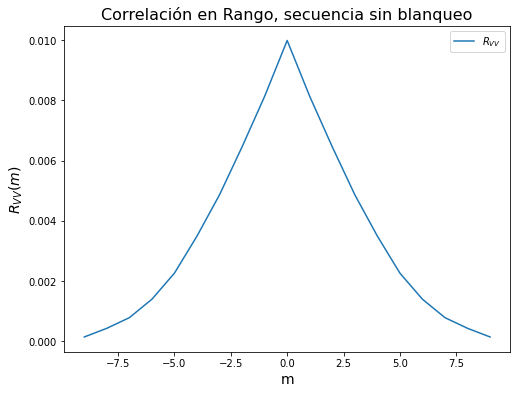

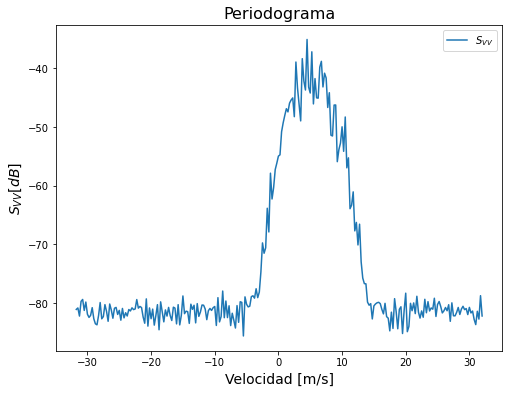

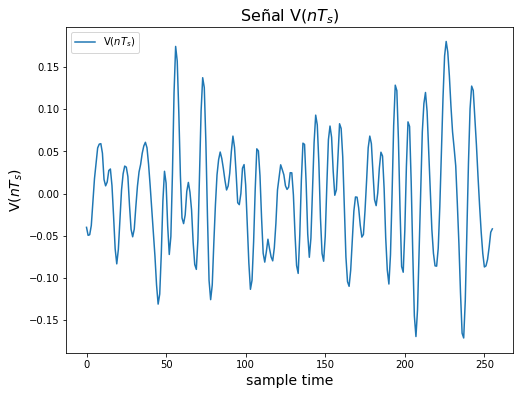

In [6]:
import numpy as np
from matplotlib import pyplot as plt 


L= 10  # Factor de oversampling
F= 1   # Largo de la respuesta del filtro receptor
M= 256 # Cantidad de pulsos 
h_l= np.ones(F)  # Filtro receptor, una delta en nuestro caso ideal
p_l= np.ones(L) # L muestras del PULSO RECTANGULAR 
S = 10 # Potencia media de la señal de meteorológica, en dBm
sigma_v = 2 # Ancho de banda Doppler, en m/s
v_amax = 32 # Max velocidad ambigüa, en m/s
v_mean = 5 # Velocidad Doppler media, en m/s
Pn = -20  # Potencia de ruido, en dBm
lamb= 0.1 # Frecuencia de operanción, en m 

# Datos sintetizados

V= datos_sinteticos(M, L, F, p_l, h_l, S, Pn, v_mean, sigma_v, lamb, v_amax)

# Gráficas 

x= np.arange(-L+1, L)

y= np.zeros(2*L-1, dtype= 'complex_')

for i in range(M):
    y += 1/(L*M) * np.correlate(V[:,i], V[:,i], "full") # Correlación en Rango sin traf. de blanqueo


# Correlación sin blanqueo
plt.figure(0, figsize=(8,6))
plt.plot(x, np.real(y), label='$R_{VV}$')
plt.legend()
plt.title('Correlación en Rango, secuencia sin blanqueo', fontdict= {'size': 16})
plt.xlabel('m', fontdict= {'size': 14})
plt.ylabel('$R_{VV}(m)$', fontdict= {'size': 14})
plt.show()

# Periodograma

Fs= 4*v_amax / lamb  # Frecuencia de muestro
Ts= 1/Fs  # Tiempo de muestro
Sx= np.zeros(M)
for j in range(L):
    Sx +=1/L * np.abs(np.fft.fftshift(np.fft.fft(V[j,:])))**2 * Ts/M # Densidad espectral
Sx = 10*np.log10(Sx)
freq = np.arange(-M/2, M/2, 1)*-2*v_amax/M # Freq [Hz]

# Plot del periodograma
plt.figure(4, figsize=(8,6))
plt.plot(freq,Sx, label='$S_{VV}$')
plt.legend()
plt.title('Periodograma', fontdict= {'size': 16})
plt.xlabel('Velocidad [m/s]', fontdict= {'size': 14})
plt.ylabel('$S_{VV}[dB]$', fontdict= {'size': 14})
plt.show()

# Señal 

m= np.arange(M)
plt.figure(5, figsize=(8,6))
plt.plot(m,np.real(V[1,:]), label='V($nT_s$)')
plt.legend()
plt.title('Señal V($nT_s$)',fontdict= {'size': 16})
plt.xlabel('sample time',fontdict= {'size': 14} )
plt.ylabel('V($nT_s$)',fontdict= {'size': 14} )
plt.show()


## Conclusiones

* Se implentó una función que simula datos sobremuestreados de radar meteorológico.
* La señal obtenida tiene correlación en rango y tiempo. Para poner a prueba el simulador, se anlizó un sistema ideal: ancho de banda infinito en el receptor, $h(l)=\delta (l)$, y pulso rectangular ideal de duración $\tau$.
* Se graficó la autocorrelación en rango, períodograma y la señal $V$ para un determinado rango.

## Trabajo futuro

* Agregar polarización dual.
* Estudiar el comportamiento para sistemas con pulsos rectangulares no ideales y receptor con ancho de banda finito.
* Aplicar transformación de blanqueo a los datos generados y estudiar cuándo los estimadores resultan de menor varianza a los obtenidos sin alplicar la transformación de blanqueo.

## Referencias

* Torres, S., 2001: ESTIMATION OF DOPPLER AND POLARIMETRIC VARIABLES FOR WEATHER RADARS. Ph.D dissertation, University of Oklahoma.
* Torres, S. and D.S.Zrinc, 2003: Whitening in Range to Improve Weather Radar Spectral Moment Estimates.
Part I: Formulation and Simulation. J. Atmos. Oceanic Technol., 20, 1433-1448.